# Exploratory Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

## Initial exploration to guide preprocessing

In [2]:
df_raw = pd.read_csv('../data/raw/train.csv') 
df_raw.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


### Target distribution

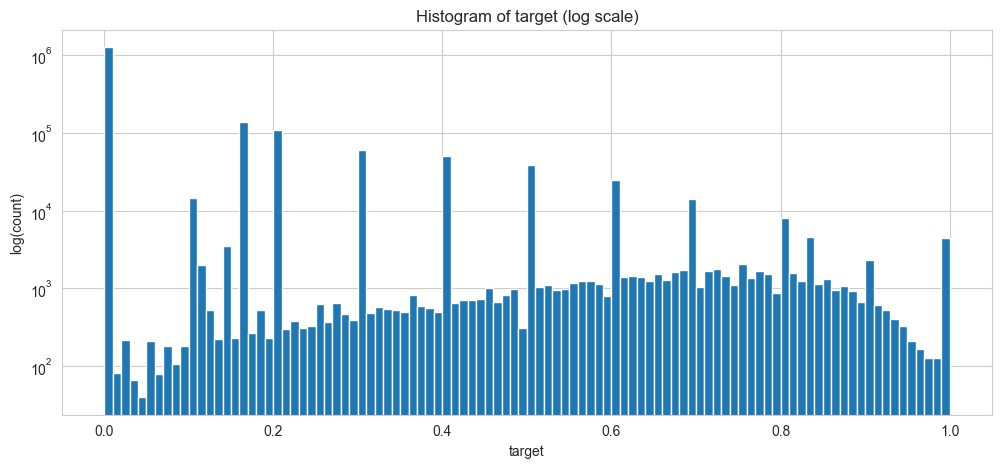

In [3]:
plt.figure(figsize=(12, 5))
df_raw['target'].hist(bins=100)
plt.yscale('log')
plt.xlabel('target')
plt.ylabel('log(count)')
plt.title('Histogram of target (log scale)')
plt.show()

In [4]:
print('Target mean:', df_raw['target'].mean())
print('90th percentile (useful for thresholding strategies):', df_raw['target'].quantile(0.9))

Target mean: 0.10301729306269818
90th percentile (useful for thresholding strategies): 0.4


### Check for missing values

In [5]:
df_raw.isna().sum()

id                                           0
target                                       0
comment_text                                 3
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male         

In [6]:
# Preview NaNs in 'comment_text' (these will need to be removed)
df_raw[df_raw['comment_text'].isna()]

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
513346,872115,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,163140,approved,5,0,0,9,1,0.0,0,4
1010795,5353666,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,340316,approved,0,0,0,0,0,0.0,4,4
1512317,5971919,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,378393,approved,0,0,0,1,0,0.0,4,4


### Date parsing and distribution over time

The earliest date:  2015-09-29 10:50:41.987077
The latest date:  2017-11-11 01:01:10.822969


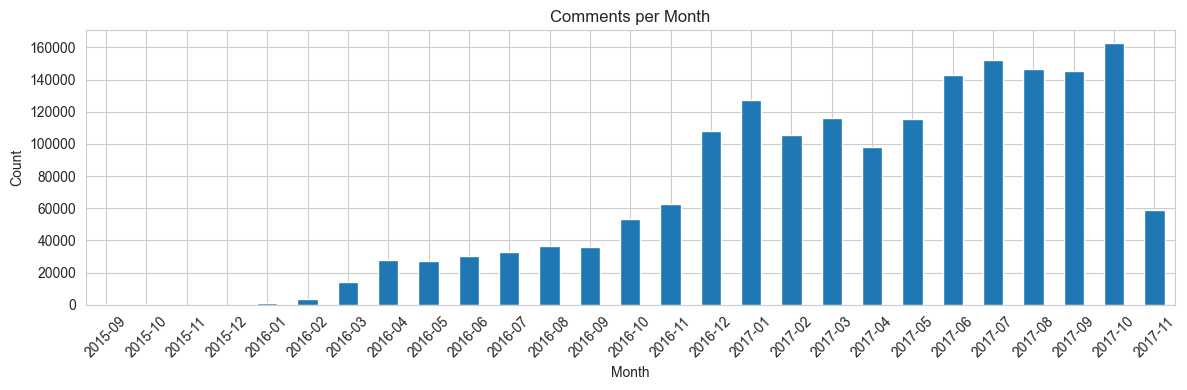

In [7]:
df_raw['created_date'] = pd.to_datetime(df_raw['created_date'], errors='coerce').dt.tz_localize(None)
print('The earliest date: ', df_raw['created_date'].min())
print('The latest date: ', df_raw['created_date'].max())

monthly_counts = df_raw['created_date'].dt.to_period('M').value_counts().sort_index()
months_str = monthly_counts.index.strftime('%Y-%m')

monthly_counts.plot(kind='bar', figsize=(12, 4))
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Comments per Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

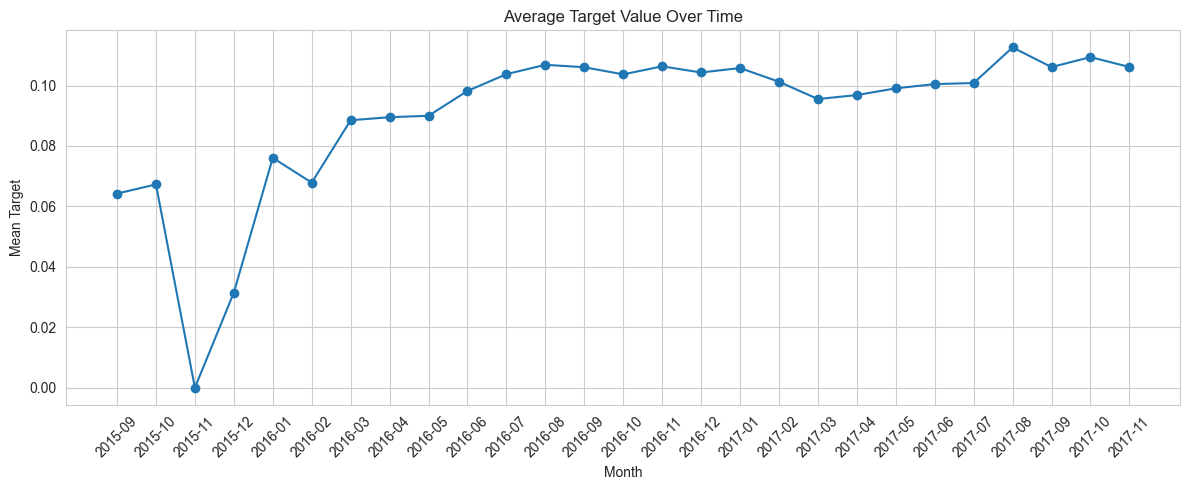

In [8]:
df_raw['month'] = df_raw['created_date'].dt.to_period('M')

plt.figure(figsize=(12, 5))
monthly_means = df_raw.groupby('month')['target'].mean()
monthly_means.index = monthly_means.index.astype(str)

plt.plot(monthly_means.index, monthly_means.values, marker='o')
plt.title('Average Target Value Over Time')
plt.ylabel('Mean Target')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## After Preprocessing

In [9]:
df_processed = pd.read_csv('../data/processed/train.csv') 
df_processed.head()

,id,comment_text,created_date,target,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
0,5175496,It's time for a finish fight on this issue. Ca...,2017-04-25 06:10:43.915306,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,5320902,For you and I it would be a criminal act and J...,2017-05-29 10:07:29.931982,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,988332,What a surprise - the police investigate one o...,2017-02-13 12:05:10.593276,0.166667,0.0,0.0,0.0,0.166667,0.0,0.0
3,315814,"David you mocked yourself in that post. ""As Ma...",2016-05-16 09:05:24.250145,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
4,730689,"You can say those things, but some of them are...",2016-12-19 22:02:36.055497,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


In [10]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797335 entries, 0 to 797334
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               797335 non-null  int64  
 1   comment_text     797335 non-null  object 
 2   created_date     797335 non-null  object 
 3   target           797335 non-null  float64
 4   severe_toxicity  797335 non-null  float64
 5   obscene          797335 non-null  float64
 6   identity_attack  797335 non-null  float64
 7   insult           797335 non-null  float64
 8   threat           797335 non-null  float64
 9   sexual_explicit  797335 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 60.8+ MB


In [11]:
df_processed.describe(include='all')

,id,comment_text,created_date,target,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
count,7.973350e+05,797335,797335,797335.000000,797335.000000,797335.000000,797335.000000,797335.000000,797335.000000,797335.000000
unique,NaN,788598,796933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Sᴛᴀʀᴛ ᴡᴏʀᴋɪɴɢ ғʀᴏᴍ ʜᴏᴍᴇ! Gʀᴇᴀᴛ ᴊᴏʙ ғᴏʀ sᴛᴜᴅᴇɴᴛ...,2015-10-13 17:49:57.721612,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,91,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.039690e+06,NaN,NaN,0.100721,0.004466,0.013856,0.021450,0.079520,0.009060,0.006530
std,2.077953e+06,NaN,NaN,0.195027,0.022565,0.065011,0.076022,0.174207,0.048785,0.044967
min,5.984800e+04,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.487100e+05,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.543520e+05,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.035898e+06,NaN,NaN,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Correlation heatmap

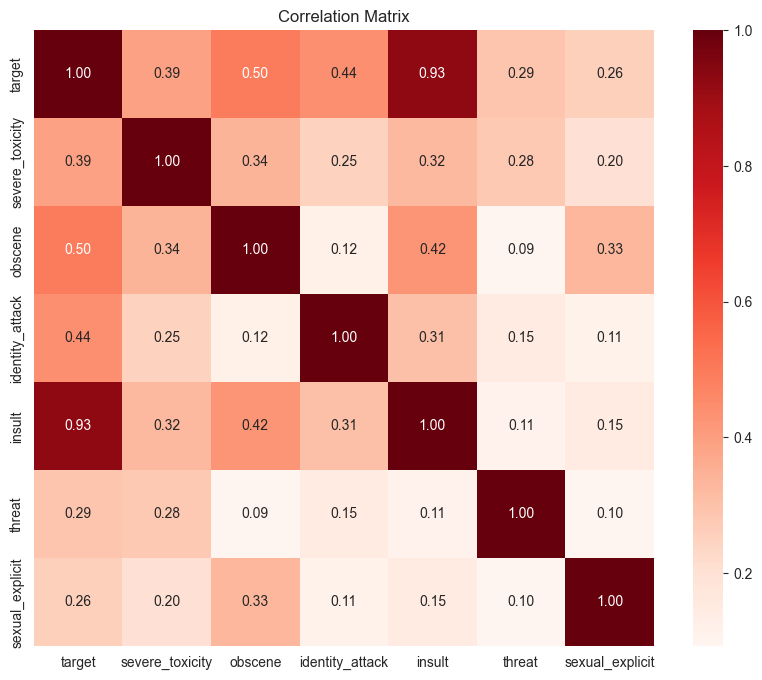

In [12]:
correlation_matrix = df_processed.drop('id', axis=1).corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='Reds')
plt.title('Correlation Matrix')
plt.show()

### Text statistics

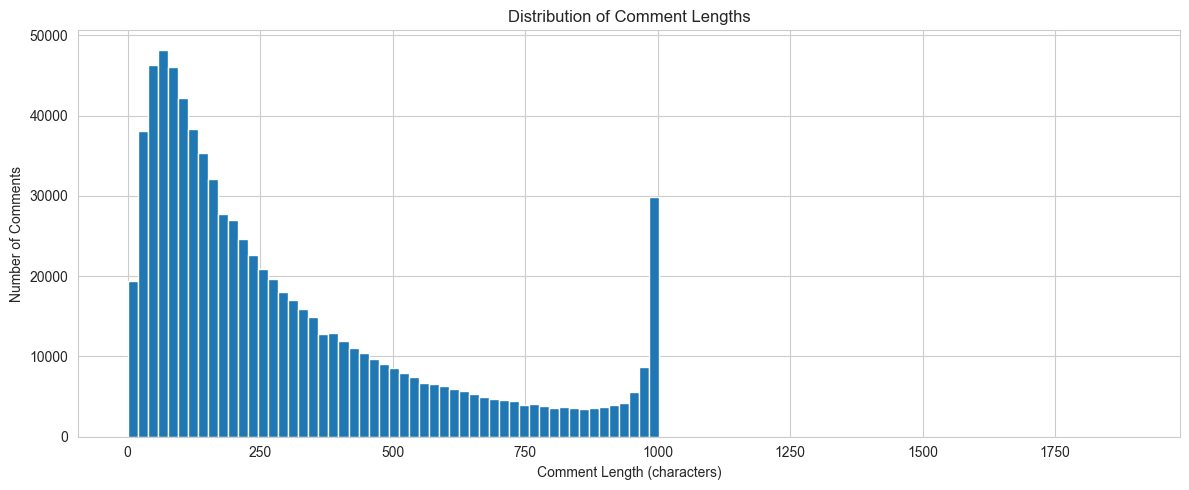

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
df_processed['comment_text'].str.len().hist(bins=100)
plt.xlabel('Comment Length (characters)')
plt.ylabel('Number of Comments')
plt.title('Distribution of Comment Lengths')
plt.tight_layout()
plt.show()

### Sample highly toxic examples

In [14]:
df_processed[df_processed['target'] == 1.0].sample(5)

,id,comment_text,created_date,target,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
744554,835331,The Trumpaphobes have their knickers in a twis...,2017-01-13 18:30:13.899520,1.0,0.0,0.0,0.0,1.0,0.0,0.0
60050,4979471,Cassie ... While I admire your tireless albeit...,2017-03-09 03:16:20.725437,1.0,0.0,0.0,0.0,1.0,0.0,0.0
131377,240961,Where do you get the Sour Grapes to say this i...,2016-01-27 08:43:16.933783,1.0,0.0,1.0,0.0,1.0,0.0,0.0
106387,1027344,Cry Baby Trump and his diapered minions never ...,2017-02-22 00:51:44.088274,1.0,0.0,0.0,0.0,1.0,0.0,0.0
469050,947415,"What a selfish, narrow-minded remark! This man...",2017-02-04 01:41:19.893066,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [15]:
df_processed[df_processed['severe_toxicity'] >= 0.4].sample(5)

,id,comment_text,created_date,target,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
267883,683309,Off with his head.,2016-12-09 04:41:53.794539,0.900000,0.40000,0.100000,0.000000,0.100000,0.900000,0.00000
718828,680030,"""immiserate"": transitive verb, meaning to make...",2016-12-08 17:40:19.034949,0.800000,0.50000,0.800000,0.800000,0.800000,0.000000,0.00000
480718,560970,"Good try, but FAT chance I would rather have C...",2016-10-29 03:30:55.323067,0.700000,0.40000,0.200000,0.000000,0.600000,0.000000,0.40000
385797,854010,"Fuck your mama, and fuck your civility standar...",2017-01-17 19:49:30.738071,0.983961,0.45258,0.974895,0.021618,0.921199,0.723152,0.63947
235180,1080127,"It's white genocide, the parasites, their boug...",2017-03-05 14:58:08.915499,0.600000,0.40000,0.100000,0.600000,0.500000,0.100000,0.00000


### Keyword correlation analysis

In [16]:
# Convert comments into bag-of-words with the 1000 most frequent words
vec = CountVectorizer(stop_words='english', max_features=1000)
X = vec.fit_transform(df_processed['comment_text'])

# Extract the most toxic and least toxic comments
X_toxic = X[(df_processed['target'] >= 0.7).values]
X_non_toxic = X[(df_processed['target'] < 0.1).values]

# Calculate mean word frequency
toxic_corr = np.array(X_toxic.mean(axis=0)).flatten()
non_toxic_corr = np.array(X_non_toxic.mean(axis=0)).flatten()

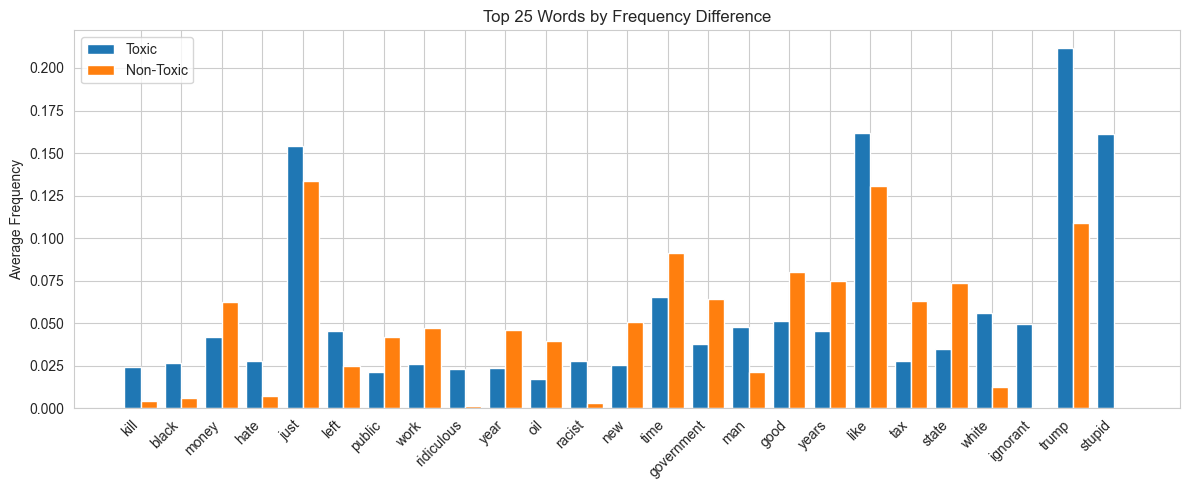

In [17]:
# Compute frequency difference per word
words = vec.get_feature_names_out()
diff = toxic_corr - non_toxic_corr

# Select top 25 words with the largest absolute frequency difference
top_indices = np.argsort(np.abs(diff))[-25:]

plt.figure(figsize=(12, 5))
x = np.arange(len(top_indices))
plt.bar(x - 0.2, toxic_corr[top_indices], width=0.4, label='Toxic')
plt.bar(x + 0.2, non_toxic_corr[top_indices], width=0.4, label='Non-Toxic')
plt.xticks(x, words[top_indices], rotation=45, ha='right')
plt.ylabel('Average Frequency')
plt.title(f'Top 25 Words by Frequency Difference')
plt.legend()
plt.tight_layout()
plt.show()